# U-NET Pytorch Implementation

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torchsummary import summary
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu" 

### Loading  Dataset

Using the Semantic Drone Dataset from Kaggle. Upload your kaggle.json file and move it to the root/.kaggle directory 




In [3]:
%mkdir ../root/.kaggle
%mv kaggle.json ../root/.kaggle/kaggle.json

In [4]:
!chmod 600 ../root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset

100% 3.89G/3.89G [01:05<00:00, 44.9MB/s]
100% 3.89G/3.89G [01:05<00:00, 63.6MB/s]


In [6]:
!unzip semantic-drone-dataset.zip &> /dev/null

In [7]:
class SemanticDroneDataset(Dataset):

    def __init__(self, annotations_file, image_dir, label_image_dir, transforms=None):
        self.class_labels = pd.read_csv(annotations_file)
        self.image_dir = image_dir
        self.label_image_dir = label_image_dir
        self.transforms = transforms

        self.image_files = sorted(os.listdir(image_dir))
        self.label_image_files = sorted(os.listdir(label_image_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_image_path = os.path.join(self.label_image_dir, self.label_image_files[idx])

        image = read_image(image_path)
        label_image = read_image(label_image_path)

        if self.transforms:
            image = self.transforms(image)
            label_image = self.transforms(label_image)

        label_masks = torch.zeros(24, 200, 300)

        for i, row in self.class_labels.iterrows():
            r = int(row[' r'])
            g = int(row[' g'])
            b = int(row[' b'])

            label_masks[i, :, :] = torch.logical_and(
                torch.logical_and(label_image[0, :, :] == r, label_image[1, :, :] == g),
                label_image[2, :, :] == b
            )

        image = image.float() / 255

        return image, label_masks

In [8]:
transforms = nn.Sequential(
    T.Resize((200, 300)),
)

In [9]:
semantic_drone_dataset = SemanticDroneDataset(
    './class_dict_seg.csv', 
    './dataset/semantic_drone_dataset/original_images', 
    './RGB_color_image_masks/RGB_color_image_masks',
    # './dataset/semantic_drone_dataset/label_images_semantic',
    transforms)

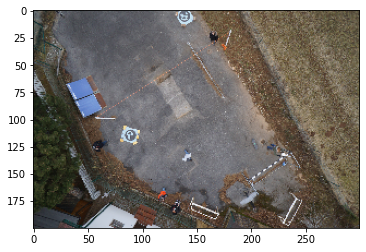

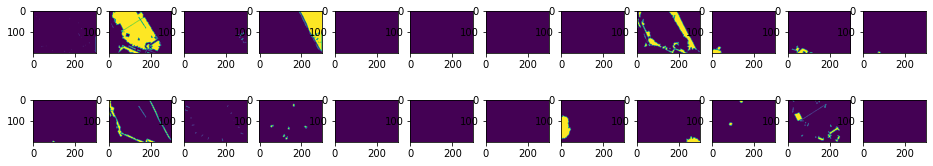

In [10]:
x, y = semantic_drone_dataset[1]

plt.imshow(x.permute(1, 2, 0))
plt.show()

plt.figure(figsize=(16, 3))

for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(y[i, :, :])

plt.show()

In [11]:
m = len(semantic_drone_dataset)
train_data, val_data = random_split(semantic_drone_dataset, [int(m - m * 0.2), int(m * 0.2)])

In [19]:
train_loader = DataLoader(train_data, batch_size=16)
val_loader = DataLoader(val_data, batch_size=8)

### Model

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(ConvBlock(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(ConvBlock(feature * 2, feature))

        self.bottleneck = ConvBlock(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        x = self.bottleneck(x)
        skip_connections = list(reversed(skip_connections))

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i + 1](concat_skip)

        return self.final_conv(x)

In [14]:
unet = UNET(3, 24).to(device)
summary(unet, (3, 300, 200), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 200]           1,728
       BatchNorm2d-2         [-1, 64, 300, 200]             128
              ReLU-3         [-1, 64, 300, 200]               0
            Conv2d-4         [-1, 64, 300, 200]          36,864
       BatchNorm2d-5         [-1, 64, 300, 200]             128
              ReLU-6         [-1, 64, 300, 200]               0
         ConvBlock-7         [-1, 64, 300, 200]               0
         MaxPool2d-8         [-1, 64, 150, 100]               0
            Conv2d-9        [-1, 128, 150, 100]          73,728
      BatchNorm2d-10        [-1, 128, 150, 100]             256
             ReLU-11        [-1, 128, 150, 100]               0
           Conv2d-12        [-1, 128, 150, 100]         147,456
      BatchNorm2d-13        [-1, 128, 150, 100]             256
             ReLU-14        [-1, 128, 1

### Training

In [15]:
criterion = nn.BCEWithLogitsLoss() # Best choice for the loss function???
optimizer = optim.Adam(unet.parameters(), lr=1e-4)
scalar = torch.cuda.amp.GradScaler()

In [28]:
for epoch in range(5):

    print(f"Epoch {epoch}")

    for batch_i, (X, Y) in enumerate(train_loader):
        X = X.to(device)
        Y = Y.to(device)
        
        with torch.cuda.amp.autocast():
            predictions = unet(X)
            loss = criterion(predictions, Y)

        optimizer.zero_grad()
        scalar.scale(loss).backward()
        scalar.step(optimizer)
        scalar.update()

        print("Loss", loss.item())
        

Epoch 0
Loss 0.06071958690881729
Loss 0.08264219015836716
Loss 0.06826665252447128
Loss 0.08483923971652985
Loss 0.08413262665271759
Loss 0.07973816245794296
Loss 0.07260781526565552
Loss 0.0733315572142601
Loss 0.07107105851173401
Loss 0.08160184323787689
Loss 0.0738220140337944
Loss 0.07273222506046295
Loss 0.07903458923101425
Loss 0.07556851953268051
Loss 0.08694130927324295
Loss 0.07904399186372757
Loss 0.0787762776017189
Loss 0.08844941109418869
Loss 0.08216125518083572
Loss 0.07359784841537476
Epoch 1
Loss 0.06459756940603256
Loss 0.06167786568403244
Loss 0.07248744368553162
Loss 0.06933578103780746
Loss 0.0792493224143982
Loss 0.07136432081460953
Loss 0.07648292183876038
Loss 0.09228570014238358
Loss 0.07383032888174057
Loss 0.07811855524778366
Loss 0.06872627884149551
Loss 0.08034957945346832
Loss 0.0770997628569603
Loss 0.07476496696472168
Loss 0.0815318152308464
Loss 0.08526913821697235
Loss 0.07753340899944305
Loss 0.07806732505559921
Loss 0.061451900750398636
Loss 0.0893874

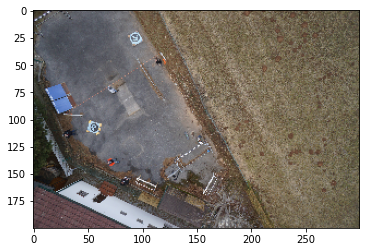

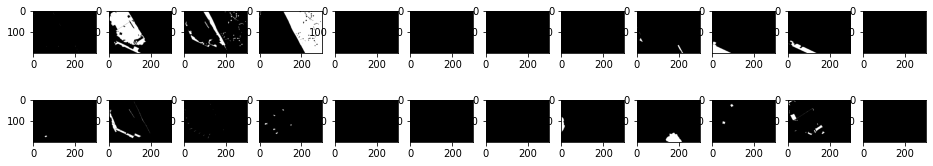

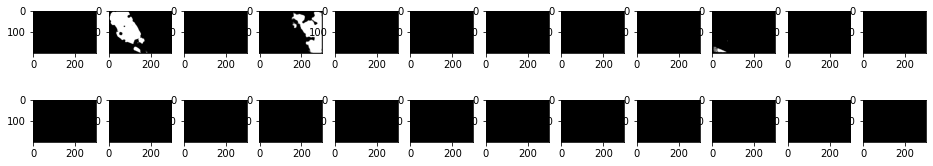

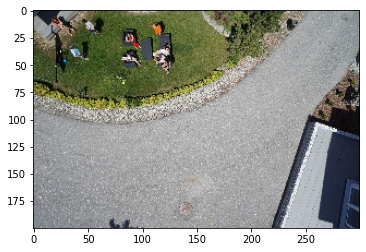

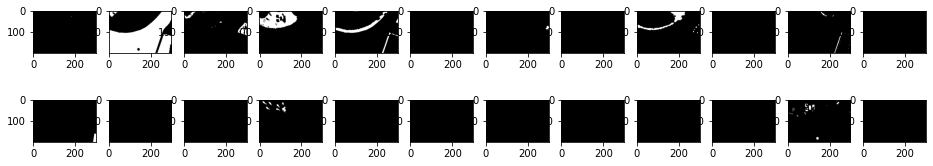

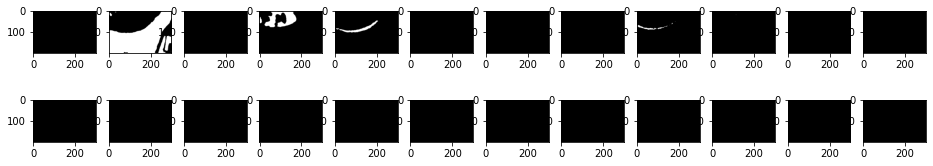

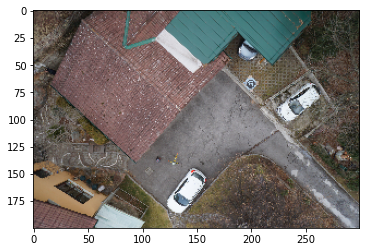

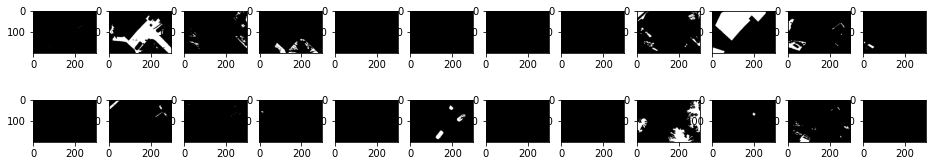

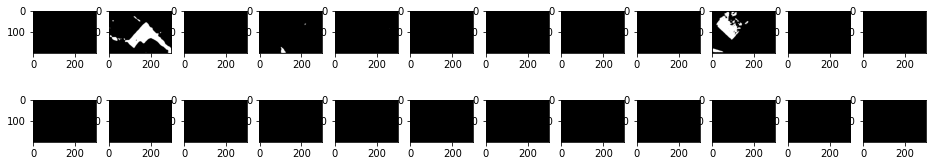

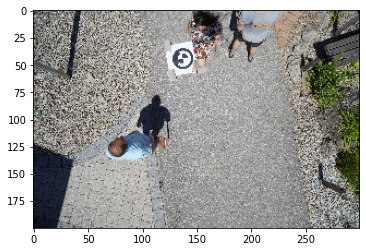

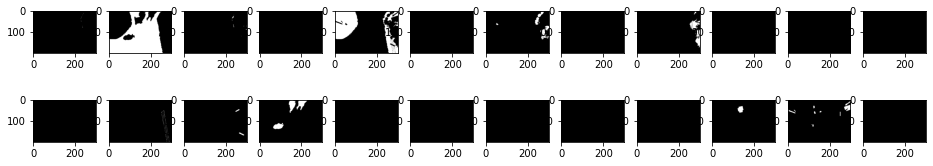

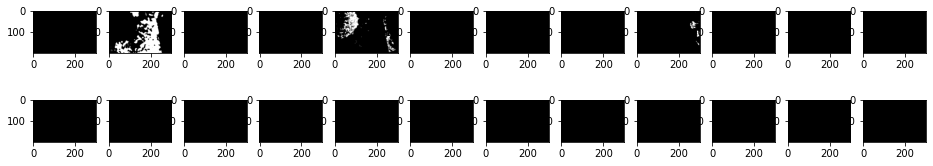

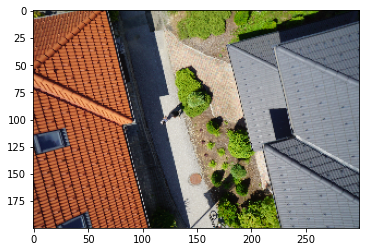

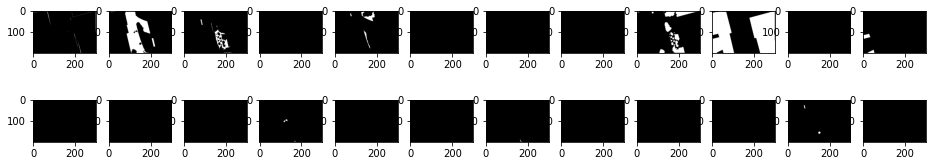

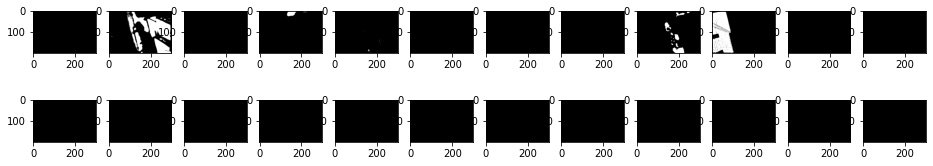

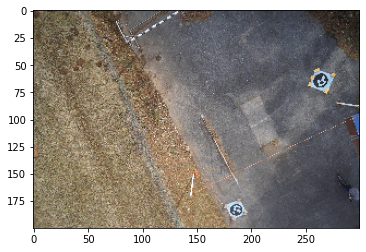

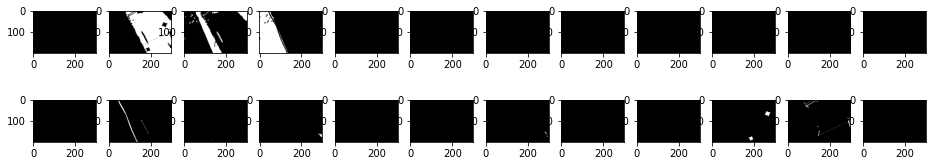

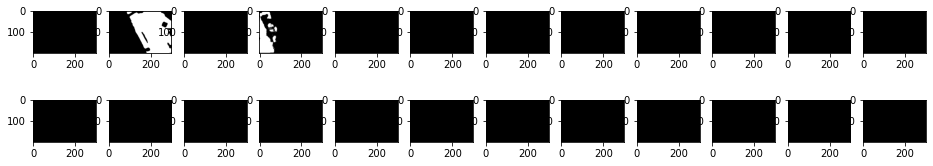

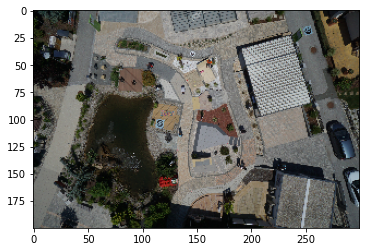

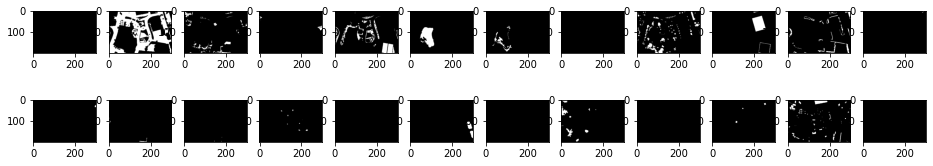

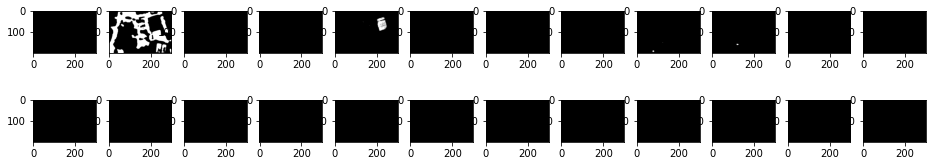

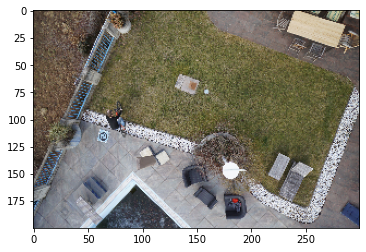

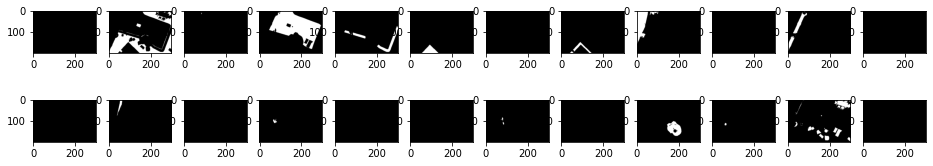

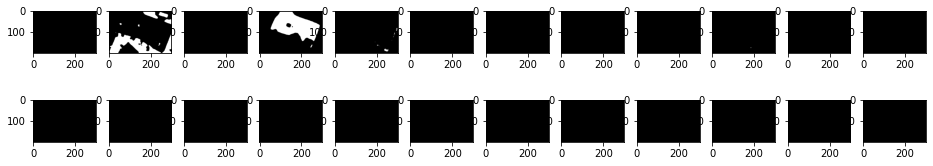

In [29]:
with torch.no_grad():

    unet.eval()

    for batch_i, (X, Y) in enumerate(val_loader):
        
        X = X.to(device)
        Y = Y.to(device)

        prediction = unet(X)

        plt.figure(figsize=(6, 4))

        for i in range(X.shape[0]):
            check_x = X[i]
            check_pred = prediction[i] > 0.5
            check_y = Y[i]

            plt.imshow(check_x.cpu().permute(1, 2, 0))

            plt.figure(figsize=(16, 3))
            for i in range(24):
                plt.subplot(2, 12, i + 1)
                plt.imshow(check_y[i, :, :].cpu(), cmap="gray")

            plt.figure(figsize=(16, 3))
            for i in range(24):
                plt.subplot(2, 12, i + 1)
                plt.imshow(check_pred[i, :, :].cpu(), cmap="gray")

            plt.show()
        break